# Z1 Data RnD
## Properties-based-Properties Colaborative Filtering Algorithm

We are trying to find an algorithm that can solve our problems. the problem is we want an algorithm that can define similar items. However, in terms of similarity there's usually being like _"Similar Items based on **anything**"_. Mostly, Data Scientist always define the similarity based on user information/behaviors.

With our problem, we are not defining item similarity based on user information. This is the challanges that we are over-thinkig about that. instead of user information we found that we can also do this by **scoring the items**. So that, the senario to do is firstly we need to change the category values to numeric representing as Matrix by using **CountVectorizer**, and then we will be able to perform any Cosine Similarity to determine which items is the most similar. this similarities are also representing as Matrix.

_Let us go through implementation of the Algorithm._

### 1. Import required Libraries

In [329]:
#import Essential Libraries
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### 2. Dataset
_Import the data from Postgre Database for training. The dataset is (10 columns and 100 rows)_

In [338]:
# Point to Postgre Database and Assign as a variable
con = psycopg2.connect(
            host = "192.168.22.131",
            database="Z1_Cloud_Backup",
            user = "postgres",
            password = "Z1@$2020")
cur = con.cursor()

# Define sql Statement and Execute and Assign as a var named data
cur.execute('''-- from database: Z1_Cloud_Backup
select (row_number() over(order by id) -1) as index, id,
case when record_type is null then 'Others' else record_type end as record_type, 
case when type is null then 'Others' else type end as type,
case when current_use = 'N/A' then null when current_use = 'null' then null else current_use end as current_use, 
case when land_shape_type = 'null' then null else land_shape_type end as land_shape_type,   
site_position, is_rent, is_sale, is_appraisal
from public.properties where id is not null limit 100;''')
data = cur.fetchall()

#create it as a dataframe 
cols = []
for elt in cur.description:
    cols.append(elt[0])
pd.set_option("display.max_columns", None)
properties = pd.DataFrame(data = data, columns = cols)
properties.head(5)

,index,id,record_type,type,current_use,land_shape_type,site_position,is_rent,is_sale,is_appraisal
0,0,92,Land,Agricultural Land,None,None,None,None,True,True
1,1,93,Land,Vacant Land,Unimproved Land,Rectangle,None,False,True,True
2,2,94,Land,Agricultural Land,Orchards,Rectangle,Intermediate Lot,None,True,True
3,3,95,Land and Building,Commercial Property,Restaurant,Rectangle,Corner Lot,None,True,True
4,4,96,Land,Vacant Land,Improved Land,Rectangle,Intermediate Lot,False,True,True


### 3. Missing Values

In [291]:
# view info of dataframe
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            100 non-null    int64 
 1   id               100 non-null    int64 
 2   record_type      100 non-null    object
 3   type             100 non-null    object
 4   current_use      93 non-null     object
 5   land_shape_type  99 non-null     object
 6   site_position    94 non-null     object
 7   is_rent          90 non-null     object
 8   is_sale          100 non-null    bool  
 9   is_appraisal     100 non-null    bool  
dtypes: bool(2), int64(2), object(6)
memory usage: 6.6+ KB


**Seeing that the dataset has 10 columns** representing as the following:

- **_index_** is representing as row numbers that counting from 0. 
- **_id_** represents the unique id of each property.
- _**record_type**, **type**, and **current_use**_ are the _categorical fileds_ representing the types of each property. _record_type_ is the first priority, _type_ is the second priority, and the _current_use_ is the third priority. 
- _**land_shape_type**_ shows the shape of those properties which is launched in the dataset. Those shapes are such as _Rectangle_, _Irregular_, _Square_, or _Triangle_, etc. 
- _**site_position**_ is another columns representing position of properties' site. For instance, is it staying at Corner Lot or others? 
- _**is_rent** and **is_sale**_ are showing as binary values in which those properties are for rent or for sale, or for both of rent and sale.
- **is_appraisal** is also showing binary values in which those properties are evaluated or not.

**In this section**, we will face with _Missing Values_ and _Features Combination_.

<AxesSubplot:>

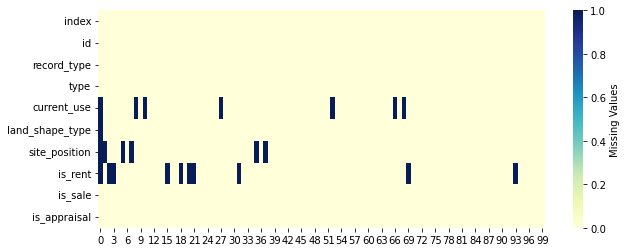

In [292]:
# plot the Heatmap to visualize the missing values
plt.figure(figsize=(10,4))
sns.heatmap(properties.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Values'})

The dataset has some missing values in four columns. Those are _**current_use**, **land_shape_type**, **is_rent**, and **site_position**_. To solve this, we would happen to fill `''` in the missing values.

In [293]:
# fill categorical fields by "Others" in missing values
properties[["type", 
            "current_use",
            "land_shape_type", 
            "site_position"]] = properties[["type", 
                                            "current_use", 
                                            "land_shape_type", 
                                            "site_position"]].fillna('')

# fill fields of binary values by '' in missing values
properties[["is_rent", 
            "is_sale", 
            "is_appraisal"]] = properties[["is_rent", 
                                           "is_sale", 
                                           "is_appraisal"]]. fillna('')
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            100 non-null    int64 
 1   id               100 non-null    int64 
 2   record_type      100 non-null    object
 3   type             100 non-null    object
 4   current_use      100 non-null    object
 5   land_shape_type  100 non-null    object
 6   site_position    100 non-null    object
 7   is_rent          100 non-null    object
 8   is_sale          100 non-null    bool  
 9   is_appraisal     100 non-null    bool  
dtypes: bool(2), int64(2), object(6)
memory usage: 6.6+ KB


Now, there's no more missing values in our dataset. So that we can concat all values of each column, representing as a new column named **_categories_**

In [294]:
# concat all columns and include as a new column named categories
def combined_features(row):
    return str(row['record_type'])+" "+str(row['type'])+" "+str(row['current_use'])+" "+str(row['land_shape_type'])+" "+str(row['site_position'])+" "+str(row['is_rent'])+" "+str(row['is_sale'])+" "+str(row['is_appraisal'])
properties["categories"] = properties.apply(combined_features, axis =1)

The new column named categories is representing values as text. However, the model cannot be smoothly calculated if the documents still contain operators. To do this, we are next going to remove all operators in the column _categories_.  

In [295]:
# import regular Expression operation
import re

# define a function for removing operators.
def remove_operators(categories):
    return re.sub("[^a-zA-Z0-9 ]", "", categories)
properties["categories"] = properties["categories"].apply(remove_operators)
properties["categories"].values.tolist()

['Land Agricultural Land     True True',
 'Land Vacant Land Unimproved Land Rectangle  False True True',
 'Land Agricultural Land Orchards Rectangle Intermediate Lot  True True',
 'Land and Building Commercial Property Restaurant Rectangle Corner Lot  True True',
 'Land Vacant Land Improved Land Rectangle Intermediate Lot False True True',
 'Land Vacant Land Improved Land Rectangle  False True True',
 'Land Vacant Land Unimproved Land Rectangle Intermediate Lot False True True',
 'Land Vacant Land NonImproved Land Rectangle  False True True',
 'Land Agricultural Land  Rectangle Intermediate Lot False True True',
 'Land Vacant Land Improved Land Rectangle Intermediate Lot False True True',
 'Land and Building Mixeduse  Rectangle Corner Lot False True True',
 'Land Vacant Land Improved Land Rectangle Intermediate Lot False True True',
 'Land Vacant Land Unimproved Land Irregular Corner Lot False True True',
 'Land and Building Commercial Property Restaurant Rectangle Intermediate Lot Fal

### 4. Count Vectorizer the values of listing

_Let's see the sample of Count-Vectorizer. This method trys to count the numbers of terms or words in each document as representing in the following;_

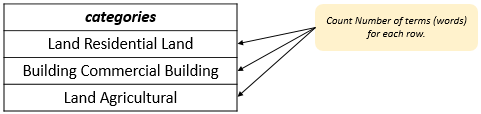

_It then generates as below;_

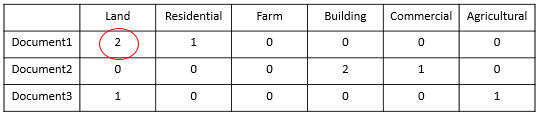

For interpretation, there are two words of Land in the document1, so that the Count-Vectorizer counts this word and and represent as number 2. and so on.

In [327]:
# count number terms, generate as metrix, and assign as a variable
cv = CountVectorizer()
matrix = cv.fit_transform(properties["categories"])
print(matrix.toarray())

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


### 5. Cosine Similarities

_Let's also see the sample of Cosine Similarity. The Cosine Similarity trys to calculate the percentages of similarities between each document_.

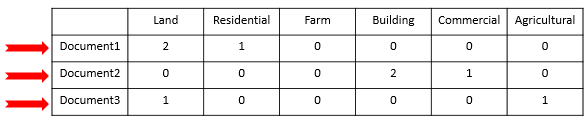

_The calculation is calculated by comparing between two-by-two vectors. As showing below, This is the comparison between document1 and document2._ 

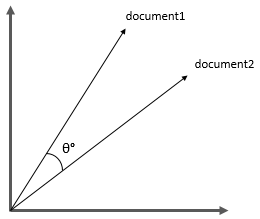

_The calculation of cosine similarity above is calculated based on its formula as representing below;_

`Cos(x, y) = x . y / ||x|| * ||y||`

where 
- x . y = product (dot) of the vectors ‘x’ and ‘y’.
- ||x|| and ||y|| = length of the two vectors ‘x’ and ‘y’.
- ||x|| * ||y|| = cross product of the two vectors ‘x’ and ‘y’.

In [328]:
#call the variable of matrix to calculate by Cosine Similarity
properties_similar_scores = cosine_similarity(matrix)

# represent as matrix of similar properties.
print(properties_similar_scores)

[[1.         0.72222222 0.58834841 ... 0.54073807 0.54073807 0.54073807]
 [0.72222222 1.         0.7190925  ... 0.91925472 0.91925472 0.86518091]
 [0.58834841 0.7190925  1.         ... 0.82717019 0.82717019 0.82717019]
 ...
 [0.54073807 0.91925472 0.82717019 ... 1.         1.         0.94736842]
 [0.54073807 0.91925472 0.82717019 ... 1.         1.         0.94736842]
 [0.54073807 0.86518091 0.82717019 ... 0.94736842 0.94736842 1.        ]]


As the result, the algorithm generates scores of property similarities as Matrix, meaning that it compares properties to properties themselves. Let's see the figure below to make more understanding.

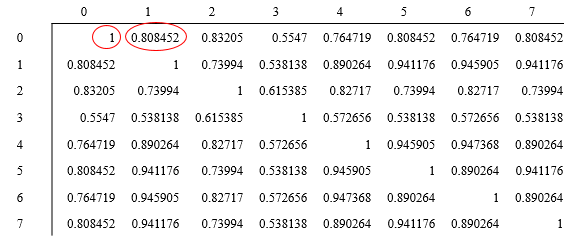

Between property0 and property0 are the same property, so that it's equal to 1, meaning that 100% of similarity between two of these. And between property1 and property0 there are a similar score about 80.84%. And so on. 

### 6. Recommendation top-similar properties

This is the input value of current_use that's input when users have viewed. Assume that, Roeun Apireak has viewed a property in which current_use is 'Improved Land'. So that, the system inputs the value 'Improved Land' into our Algorithm in a variable name `current_use_user_viewed`.

In [310]:
current_use_user_viewed = "Improved Land"

let's create a function called `get_index_from_current_use` this function can be called for retrive a specific index based on the current_use._

In [311]:
# Input [current_use], Output [index] column.
def get_index_from_current_use(current_use):
    return properties[properties.current_use == current_use]["index"].values[0]
property_index = get_index_from_current_use(current_use_user_viewed)
print(property_index)

4


_The function prints out the number 4, meaning that the index of current_use 'Improved Land' is 4._

_**Next**_ is to iterate the similarity scores, and assign it as the farmat 'list'. In this, we will have a variable named `list_similar_properties` which has all indexes of properties with every scores that comparing to the values of `current_use_user_viewed`.

In [330]:
list_similar_properties = list(enumerate(properties_similar_scores[property_index]))

_**And Then**_, Let's sort the scores as descending. you'll see the most similar properties which are similar to value of `current_use_user_viewed`. The list you see below is representing as _[index, Similar Scores]_.

In [317]:
# Sort the list by descending
desc_similar_properties = sorted(list_similar_properties, key=lambda x:x[1], reverse=True)
desc_similar_properties

[(4, 0.9999999999999996),
 (9, 0.9999999999999996),
 (11, 0.9999999999999996),
 (16, 0.9999999999999996),
 (17, 0.9999999999999996),
 (19, 0.9999999999999996),
 (22, 0.9999999999999996),
 (23, 0.9999999999999996),
 (24, 0.9999999999999996),
 (46, 0.9999999999999996),
 (49, 0.9999999999999996),
 (51, 0.9999999999999996),
 (56, 0.9999999999999996),
 (58, 0.9999999999999996),
 (59, 0.9999999999999996),
 (60, 0.9999999999999996),
 (61, 0.9999999999999996),
 (64, 0.9999999999999996),
 (74, 0.9999999999999996),
 (82, 0.9999999999999996),
 (83, 0.9999999999999996),
 (88, 0.9999999999999996),
 (90, 0.9999999999999996),
 (92, 0.9999999999999996),
 (95, 0.9999999999999996),
 (99, 0.9999999999999996),
 (20, 0.9733285267845753),
 (27, 0.9544271444636664),
 (66, 0.9544271444636664),
 (68, 0.9544271444636664),
 (6, 0.9473684210526312),
 (14, 0.9473684210526312),
 (25, 0.9473684210526312),
 (40, 0.9473684210526312),
 (42, 0.9473684210526312),
 (43, 0.9473684210526312),
 (45, 0.9473684210526312),
 (50

We are going to create a function that can return such as id and current_use back back from index. 

In [324]:
# define function that return index
def get_current_use_from_id(index):
    index = properties[properties.index == index]["index"].values[0]
    id = properties[properties.index == index]["id"].values[0]
    current_use = properties[properties.index == index]["current_use"].values[0]
    print(str(index) +", "+ str(id) +", "+ str(current_use)) # for deployment, this might be error because of data type. 

Using for-loop to return unique properties, and using Break also for determining that we will return only 10 properties which are the most similar to the value of `current_use_users_viewed`.

_The output result you see below are represented as 'index, id, current_use'._

In [325]:
i = 0
for property in desc_similar_properties:
    print(get_current_use_from_id(property[0]))
    i = i + 1
    if i == 10: #Recommend 5 similar properties back to users.
        break

4, 96, Improved Land
None
9, 101, Improved Land
None
11, 103, Improved Land
None
16, 108, Improved Land
None
17, 109, Improved Land
None
19, 111, Improved Land
None
22, 114, Improved Land
None
23, 115, Improved Land
None
24, 116, Improved Land
None
46, 138, Improved Land
None


**Therefore, our algorithm is now being able to recommend the similar properties to any users who have viewed a specific property.**

_________

### 7. Snippet of the Algorithm
We would like to prepare as a _snippet_ and also improve it as well to make sure that it's easy for using in various processing of _Microservice Architectures_.

In [29]:
#import Essential Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import sqlite3
import os
import re

# Point to Postgre Database and Assign as a variable
con = psycopg2.connect(
            host = "192.168.22.131",
            database="Z1_Cloud_Backup",
            user = "postgres",
            password = "Z1@$2020")
cur = con.cursor()

# Define sql Statement and Execute and Assign as a var named data
cur.execute('''-- from database: Z1_Cloud_Backup
select ((row_number() over(order by id)) - 1) as index, id,
case when record_type is null then 'Others' else record_type end as record_type, 
case when type is null then 'Others' else type end as type,
case when current_use = 'N/A' then null when current_use = 'null' then null else current_use end as current_use, 
case when land_shape_type = 'null' then null else land_shape_type end as land_shape_type,   
site_position, is_rent, is_sale, is_appraisal
from public.properties where id is not null limit 150;''')
data = cur.fetchall()

#create it as a dataframe 
cols = []
for elt in cur.description:
    cols.append(elt[0])
pd.set_option("display.max_columns", None)
properties = pd.DataFrame(data = data, columns = cols)

# fill categorical fields by "Others" in missing values
properties[["type", 
            "current_use",
            "land_shape_type", 
            "site_position"]] = properties[["type", 
                                            "current_use", 
                                            "land_shape_type", 
                                            "site_position"]].fillna('Others')

# fill fields of binary values by '' in missing values
properties[["is_rent", 
            "is_sale", 
            "is_appraisal"]] = properties[["is_rent", 
                                           "is_sale", 
                                           "is_appraisal"]]. fillna('')

# concat all columns and include as a new column named categories
def combined_features(row):
    return row['record_type']+" "+row['type']+" "+row['current_use']+" "+row['land_shape_type']+" "+row['site_position']+" "+str(row['is_rent'])+" "+str(row['is_sale'])+" "+str(row['is_appraisal'])
properties["categories"] = properties.apply(combined_features, axis =1)

# define a function for removing operators.
def remove_operators(categories):
    return re.sub("[^a-zA-Z0-9 ]", "", categories)
properties["categories"] = properties["categories"].apply(remove_operators)

# count number ot terms, generate as matrix, and assign as a variable
cv = CountVectorizer()
matrix = cv.fit_transform(properties["categories"])

#call the variable of matrix to calculate by Cosine Similarity
properties_similar_scores = cosine_similarity(matrix)

#This is the input value of current_use that's input when users viewed.
current_use_user_viewed = "Farms"

# Input [type], Output [index] column.
def get_index_from_current_use(current_use):
    return properties[properties.current_use == current_use]["index"].values[0]  
property_index = get_index_from_current_use(current_use_user_viewed)

# iterate similar scores, and assign as List
list_similar_properties = list(enumerate(properties_similar_scores[property_index]))

# Sort the list by descending
desc_similar_properties = sorted(list_similar_properties, key=lambda x:x[1], reverse=True)

# define function that return index
def get_current_use_from_id(index):
    index = properties[properties.index == index]["index"].values[0]
    id = properties[properties.index == index]["id"].values[0]
    current_use = properties[properties.index == index]["current_use"].values[0]
    print(str(index) +", "+ str(id) +", "+ str(current_use)) # for deployment, this might be error because of data type. 

# Recommend 10 similar properties back to users.
i = 0
for property in desc_similar_properties:
    print(get_current_use_from_id(property[0]))
    i = i + 1
    if i == 10:
        break

18, 110, Farms
None
15, 107, Improved Land
None
12, 104, Unimproved Land
None
28, 120, Farms
None
29, 121, Farms
None
39, 131, Orchards
None
47, 139, Farms
None
48, 140, Orchards
None
54, 146, Farms
None
70, 162, Orchards
None
